In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

from qiskit import *

### Función para expandir el observable

In [22]:
def expand_hamiltonian(op, total_qubits):
    expanded_paulis = []
    for pauli, coeff in zip(op.paulis, op.coeffs):
        pauli_str = pauli.to_label()
        # Añadir identidades antes y después según la posición deseada
        new_pauli = (
            pauli_str + "I" * (total_qubits - len(pauli_str))
        )
        expanded_paulis.append((new_pauli, coeff))
    return SparsePauliOp.from_list(expanded_paulis)

### Función para crear el ansatz

In [23]:
def build_deep_ansatz(num_qubits):
    """Crea un circuito con L = 10n capas de ansatz para n qubits."""
    L = 10 * num_qubits  # número de capas
    qc = QuantumCircuit(num_qubits)
    qc.ry(np.pi/4, range(num_qubits))
    qc.barrier()
    thetas = []

    def layer(qc, theta_list):
        # RX en cada qubit
        for i in range(num_qubits):
            aux = np.random.random()
            if aux < 1/3:
                qc.rx(theta_list[i], i)
            elif aux < 2/3:
                qc.ry(theta_list[i], i)
            else:
                qc.rz(theta_list[i], i)
        # CZ entre qubits adyacentes
        for i in range(num_qubits - 1):
            qc.cz(i, i + 1)

    for layer_index in range(L):
        theta_layer = [Parameter(f'θ_{layer_index}_{i}') for i in range(num_qubits)]
        thetas.append(theta_layer)
        layer(qc, theta_layer)
        qc.barrier()

    return qc, thetas

In [ ]:
def evaluate_energy(params, ansatz, hamiltonian, estimator):
    bound_ansatz = ansatz.bind_parameters(params)
    job = estimator.run([bound_ansatz], [hamiltonian])
    result = job.result()
    return result.values[0]

In [29]:
def parameter_shift_gradient(ansatz, theta_lists, hamiltonian, estimator, index, num_shots=100):
    gradient = []
    flat_params = [param for layer in theta_lists for param in layer]

    # Cálculo de gradientes
    for _ in range(num_shots):
        param_vector = np.random.uniform(0, 2 * np.pi, len(flat_params))  

        # Desplazamientos para parameter-shift
        shifted_plus = param_vector.copy()
        shifted_plus[index] += np.pi / 2
        shifted_minus = param_vector.copy()
        shifted_minus[index] -= np.pi / 2

        # Energías
        energy_plus = evaluate_energy(shifted_plus, ansatz, hamiltonian, estimator)
        energy_minus = evaluate_energy(shifted_minus, ansatz, hamiltonian, estimator)

        grad_i = 0.5 * (energy_plus - energy_minus)
        gradient.append(grad_i)

    return np.array(gradient)

In [25]:
def gradient_variance(gradient_vector):
    return np.var(gradient_vector)

In [27]:
base_hamiltonian=SparsePauliOp.from_list([("ZZ",1)])
print(base_hamiltonian)

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])


In [ ]:
for i in range (5,15):
    estimator = Estimator()

    # Expandimos el Hamiltoniano
    current_hamiltonian = expand_hamiltonian(base_hamiltonian, i)

    # Generamos el ansatz y parámetros
    ansatz, theta_layers = build_deep_ansatz(i)

    # Calculamos gradiente y varianza
    grad = parameter_shift_gradient(ansatz, theta_layers, current_hamiltonian, estimator,0)
    var = gradient_variance(grad)

    # print("Gradiente:", grad)
    print("Varianza del gradiente:", var, "para", i,"qubits")

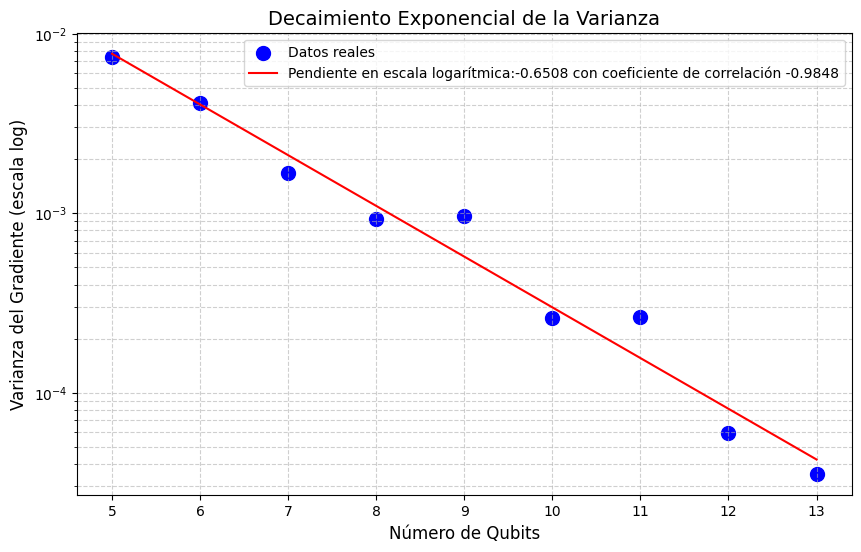

In [ ]:
qubits = np.array([5, 6, 7, 8, 9, 10, 11, 12, 13])
varianza = np.array([
    0.0074126477199148765,
    0.0041070803227110705,
    0.0016704233010868571,
    0.0009253616758467067,
    0.0009641010479317561,
    0.00026033165555921464,
    0.0002649278896421519,
    5.943840984687861e-05,
    3.530098978637608e-05])

# 1. Gráfico en escala logarítmica (varianza vs qubits)
plt.figure(figsize=(10, 6))
plt.scatter(qubits, varianza, label='Datos reales', color='blue', s=100)

# Configuración del eje Y en escala logarítmica
plt.yscale('log')
plt.xlabel('Número de Qubits', fontsize=12)
plt.ylabel('Varianza del Gradiente (escala log)', fontsize=12)
plt.title('Decaimiento Exponencial de la Varianza', fontsize=14)
plt.grid(True, which="both", ls="--", alpha=0.6)

log_varianza = np.log(varianza)
slope, intercept, r_value, p_value, std_err = stats.linregress(qubits, log_varianza)

# Predicción del modelo exponencial: y = exp(b) * exp(m * x)
varianza_ajustada = np.exp(intercept) * np.exp(slope * qubits)

# Graficar el ajuste exponencial
plt.plot(qubits, varianza_ajustada, 'r-', label=f'Pendiente en escala logarítmica:{slope:.4f} con coeficiente de correlación {r_value:.4f}')

plt.legend(fontsize=10)
plt.show()